# Custom MLP Implementation on US Census Data

By: Joe Sellett, Haiyan Cai, and Cole Wagner

## Load, Split, and Balance Data

In [1]:
import itertools
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import expit
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from statsmodels.stats.contingency_tables import mcnemar


In [2]:
# Load the data as a pandas DataFrame
census_data = pd.read_csv("acs2017_census_tract_data.csv")

In [3]:
census_data.head()
census_data.shape

(74001, 37)

In [4]:
# Remove any rows with missing values
census_nona = census_data.dropna()

In [5]:
census_nona.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72718 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           72718 non-null  int64  
 1   State             72718 non-null  object 
 2   County            72718 non-null  object 
 3   TotalPop          72718 non-null  int64  
 4   Men               72718 non-null  int64  
 5   Women             72718 non-null  int64  
 6   Hispanic          72718 non-null  float64
 7   White             72718 non-null  float64
 8   Black             72718 non-null  float64
 9   Native            72718 non-null  float64
 10  Asian             72718 non-null  float64
 11  Pacific           72718 non-null  float64
 12  VotingAgeCitizen  72718 non-null  int64  
 13  Income            72718 non-null  float64
 14  IncomeErr         72718 non-null  float64
 15  IncomePerCap      72718 non-null  float64
 16  IncomePerCapErr   72718 non-null  float64
 17

In [6]:
# Encode State column as integers

# Sort states alphabetically
unique_states = sorted(census_nona["State"].unique())
# Create a dictionary to map states to integers
state_to_int = {state: i + 1 for i, state in enumerate(unique_states)}
# Map the states to integers
census_nona["State"] = census_nona["State"].map(state_to_int)


/var/folders/jk/68j7w1pn443f9hrnsrlvphpw0000gn/T/ipykernel_27389/2779392074.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  census_nona["State"] = census_nona["State"].map(state_to_int)


In [7]:
census_nona["County"].value_counts()

County
Los Angeles County    2300
Cook County           1317
Orange County          929
Maricopa County        885
Montgomery County      822
                      ... 
Buena Vista city         1
Meagher County           1
Norton County            1
McCone County            1
Schleicher County        1
Name: count, Length: 1954, dtype: int64

In [8]:
# Drop the County column
census_nona = census_nona.drop(columns=["County"])

We decided to remove the County column due to the large number of categories. Using this in a model would require introducing almost 2000 columns into our dataset using one-hot encoding.

We believe that quantizing the data must be done separately for the training and testing data to prevent data leakage. We do not want the quantization of the testing data to be influenced by the training data. We will use the training data to determine the quantization bins and then apply the same bins to the testing data.

In [9]:
# Perform 80/20 train-test split
x_train, x_test, y_train, y_test = train_test_split(
    # Use all columns except ChildPoverty and TractId as features
    census_nona.drop(columns=["ChildPoverty", "TractId"]),
    census_nona["ChildPoverty"],
    test_size=0.2,
    random_state=7324,
)

<Axes: >

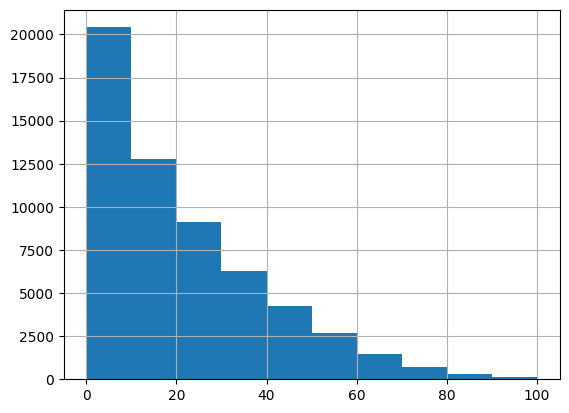

In [10]:
y_train.hist()

<Axes: >

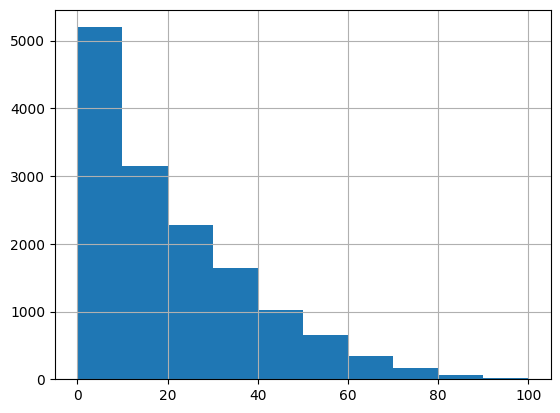

In [11]:
y_test.hist()

From the histograms above, we confirm that the distribution of ChildPoverty is similar in the training and testing sets.

In [12]:
# Quantize the training labels
y_train_cat, cuts = pd.qcut(
    y_train,
    q=4,
    labels=[0, 1, 2, 3],
    retbins=True,
)

# Apply the same quantization to the test labels
y_test_cat = []
for y in y_test:
    if y < cuts[1]:
        y_test_cat.append(0)
    elif y < cuts[2]:
        y_test_cat.append(1)
    elif y < cuts[3]:
        y_test_cat.append(2)
    else:
        y_test_cat.append(3)

In [13]:
y_test_cat = np.array(y_test_cat)

## Preprocessing and Initial Modeling

### Create MLP Classes

From https://github.com/eclarson/MachineLearningNotebooks/blob/master/08a.%20Practical_NeuralNets%20with%20Bias.ipynb

In [14]:
# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase:
    def __init__(
        self,
        n_hidden=30,
        C=0.0,
        epochs=500,
        eta=0.00001,
        random_state=None,
    ):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T

        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_) * self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_)  # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))

        W2_num_elems = (self.n_hidden) * self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden)
        b2 = np.zeros((self.n_output_, 1))

        return W1, W2, b1, b2

    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_ / 2.0) * np.sqrt(
            np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2),
        )

    def _cost(self, A3, Y_enc, W1, W2):
        """Get the objective function value"""
        cost = np.mean((Y_enc - A3) ** 2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step.

        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3

    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """Compute gradient step using backpropagation."""
        # vectorized backpropagation
        # This uses MSE as cost function
        V2 = -2 * (Y_enc - A3) * A3 * (1 - A3)
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1, axis=1).reshape((-1, 1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2

    def predict(self, X):
        """Predict class labels."""
        _, _, _, _, A3 = self._feedforward(
            X,
            self.W1,
            self.W2,
            self.b1,
            self.b2,
        )
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [15]:
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(
        self,
        shuffle=True,
        minibatches=1,
        **kwds,
    ):
        # need to add to the original initializer
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)

    def fit(self, X, y, print_progress=False, XY_test=None):
        """Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()
        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data, self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(
                accuracy_score(y_test, self.predict(X_test)),
            )
            self.val_cost_ = []

        for i in range(self.epochs):
            if print_progress > 0 and (i + 1) % print_progress == 0:
                sys.stderr.write("\rEpoch: %d/%d" % (i + 1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = (
                    X_data[idx_shuffle],
                    Y_enc[:, idx_shuffle],
                    y_data[idx_shuffle],
                )

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:
                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(
                    X_data[idx],
                    self.W1,
                    self.W2,
                    self.b1,
                    self.b2,
                )

                cost = self._cost(A3, Y_enc[:, idx], self.W1, self.W2)
                mini_cost.append(
                    cost,
                )  # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(
                    A1=A1,
                    A2=A2,
                    A3=A3,
                    Z1=Z1,
                    Z2=Z2,
                    Y_enc=Y_enc[:, idx],
                    W1=self.W1,
                    W2=self.W2,
                )

                # uUdate weights and biases
                rho_W1, rho_W2 = self.eta * gradW1, self.eta * gradW2
                self.W1 -= rho_W1
                self.W2 -= rho_W2
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(
                accuracy_score(y_data, self.predict(X_data)),
            )

            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test, yhat))

        return self

    def get_params(self, deep=True) -> dict:
        """Get the parameters of the model.

        Parameters
        ----------
        deep : bool, optional (default=True)
            Required parameter for compatibility with sklearn.

        Returns
        -------
        dict
            Parameters of the model.

        """
        return {
            "eta": self.eta,
            "C": self.l2_C,
            "epochs": self.epochs,
            "n_hidden": self.n_hidden,
            "shuffle": self.shuffle,
            "minibatches": self.minibatches,
        }

    def set_params(self, **params: dict) -> None:
        """Set the parameters of the model.

        Parameters
        ----------
        **params : dict
            Parameters to set.

        """
        for key, value in params.items():
            if key in self.get_params():
                setattr(self, key, value)
            else:
                raise ValueError(f"Invalid parameter: {key}")

In [16]:
# to implement the new style of objective function,
# we just need to update the final layer calculation of the gradient
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self, A3, Y_enc, W1, W2):
        """Get the objective function value"""
        cost = -np.mean(
            np.nan_to_num(
                Y_enc * np.log(A3 + 1e-7)
                + (1 - Y_enc) * np.log(1 - A3 + 1e-7),
            ),
        )
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """Compute gradient step using backpropagation."""
        # vectorized backpropagation
        # Now using cross-entropy as cost function
        V2 = A3 - Y_enc  # <- this is only line that changed
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1, axis=1).reshape((-1, 1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2

In [17]:
class TLPBetterInitial(TLPMiniBatchCrossEntropy):
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4 * np.sqrt(6.0 / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(
            -init_bound,
            init_bound,
            (self.n_hidden, self.n_features_),
        )

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between
        init_bound = 4 * np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W2 = np.random.uniform(
            -init_bound,
            init_bound,
            (self.n_output_, self.n_hidden),
        )

        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_output_, 1))

        return W1, W2, b1, b2

### Apply the New MLP classes to the US Census Data

In [18]:
def get_hyperparameter_combinations(param_grid: dict) -> list:
    """Generate all possible combinations of hyperparameters from a grid.

    Parameters
    ----------
    param_grid : dict
      A dictionary where keys are hyperparameter names and values are
      lists of possible settings.

    Returns
    -------
    list
      A list of dictionaries, where each dictionary represents a unique
      combination of hyperparameters.

    """
    keys, values = zip(*param_grid.items())
    combinations_list = list(itertools.product(*values))
    return [
        dict(zip(keys, combination)) for combination in combinations_list
    ]


In [19]:
def grid_search(
    nn: object,
    x: np.array,
    y: np.array,
    param_grid: dict,
) -> tuple:
    """Perform grid search to find the best hyperparameters.

    Parameters
    ----------
    nn : object
        A neural network object.
    x : np.array
        Input data.
    y : np.array
        Target labels.
    param_grid : dict
        Dictionary of hyperparameters to search.

    Returns
    -------
    pd.DataFrame
        DataFrame containing the results of the grid search.

    """
    # Create a list to store the results
    cv_results = []

    # Generate all possible combinations of hyperparameters
    hyper_combos = get_hyperparameter_combinations(param_grid)

    # Iterate over each combination of hyperparameters
    for i, params in enumerate(hyper_combos):
        # Create new instance of the classifier with the current set of parameters
        clf = nn(
            eta=params.get("eta", 0.01),
            C=params.get("C", 0.001),
            n_hidden=params.get("n_hidden", 30),
            epochs=params.get("epochs", 500),
            random_state=7324,
        )

        # Perform 5-fold cross-validation
        cv_scores = cross_val_score(
            estimator=clf,
            X=x,
            y=y,
            cv=5,
            scoring="accuracy",
        )

        # Calculate the mean accuracy and standard deviation
        mean_accuracy = np.mean(cv_scores)
        std_accuracy = np.std(cv_scores)

        # Append the results to the dataframe
        cv_results.append(
            {
                "eta": params.get("eta", 0.01),
                "C": params.get("l2_C", 0.001),
                "n_hidden": params.get("n_hidden", 30),
                "epochs": params.get("epochs", 500),
                "accuracy_mean": mean_accuracy,
                "accuracy_std": std_accuracy,
            },
        )
    # Convert the results to a DataFrame
    return pd.DataFrame(cv_results)

In [20]:
small_hyper_grid = {
    "eta": [0.000001, 0.00001],  # Learning rates
    "C": [0.0, 0.001],  # Regularization strengths
    "n_hidden": [30, 50],  # Number of neurons in hidden layer
    "epochs": [100],  # Number of epochs
}

In [21]:
# grid_results = grid_search(
#     nn=TLPBetterInitial,
#     x=x_train.to_numpy(),
#     y=y_train_cat.to_numpy(),
#     param_grid=small_hyper_grid,
# ).sort_values(by="accuracy_mean", ascending=False)

In [22]:
grid_results = pd.read_csv("grid_search_results/initial_grid_results.csv")
grid_results.head()
# grid_results.to_csv("initial_grid_results.csv", index=False)

,eta,C,n_hidden,epochs,accuracy_mean,accuracy_std
0,0.000001,0.001,50,100,0.316602,0.034591
1,0.000001,0.001,50,100,0.306407,0.039521
2,0.000001,0.001,30,100,0.301630,0.032060
3,0.000001,0.001,30,100,0.278337,0.031301
4,0.000010,0.001,30,100,0.253017,0.012482


In [23]:
best_params = grid_results.iloc[0][:4]
best_params

eta           0.000001
C             0.001000
n_hidden     50.000000
epochs      100.000000
Name: 0, dtype: float64

In [24]:
# Initialize the mlp
# mlp = TLPBetterInitial(
#     eta=best_params["eta"],
#     C=best_params["C"],
#     n_hidden=int(best_params["n_hidden"]),
#     epochs=int(best_params["epochs"]),
#     random_state=7324,
# )
# # Fit the mlp
# mlp.fit(x_train.to_numpy(), y_train_cat.to_numpy(), print_progress=10)

In [25]:
def write_pkl(obj: object, filepath: str) -> None:
    """Write an object to a pickle file.

    Parameters
    ----------
    obj : object
        The model to be serialized.
    filepath : str
        The name of the file to save the model.

    """
    with open(filepath, "wb") as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)


def read_pkl(filepath: str) -> object:
    """Read an object from a pickle file.

    Parameters
    ----------
    filepath : str
        The name of the file to read the model from.

    Returns
    -------
    object
        The deserialized model.

    """
    with open(filepath, "rb") as f:
        return pickle.load(f)


In [26]:
# Save the trained model to a file
# write_pkl(
#     mlp,
#     "models/initial_2layer.pkl",
# )

# Load the trained model from a file
mlp = read_pkl(
    "models/initial_2layer.pkl",
)

In [27]:
# Check the accuracy of the mlp on the test set
yhat = mlp.predict(x_test.to_numpy())
accuracy_score(y_true=y_test_cat, y_pred=yhat)

0.3587046204620462

In [28]:
def print_result(
    nn,
    X_train,
    y_train,
    X_test,
    y_test,
    title="",
    color="red",
):
    print("=================")
    print(title, ":")
    yhat = nn.predict(X_train)
    print("Resubstitution acc:", accuracy_score(y_train, yhat))

    yhat = nn.predict(X_test)
    print("Validation acc:", accuracy_score(y_test, yhat))

    if hasattr(nn, "val_score_"):
        plt.plot(
            range(len(nn.val_score_)),
            nn.val_score_,
            color=color,
            label=title,
        )
        plt.ylabel("Validation Accuracy")
    else:
        plt.plot(
            range(len(nn.score_)),
            nn.score_,
            color=color,
            label=title,
        )
        plt.ylabel("Resub Accuracy")

    plt.xlabel("Epochs")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.grid(True)

MLP :
Resubstitution acc: 0.364750575858631
Validation acc: 0.3587046204620462


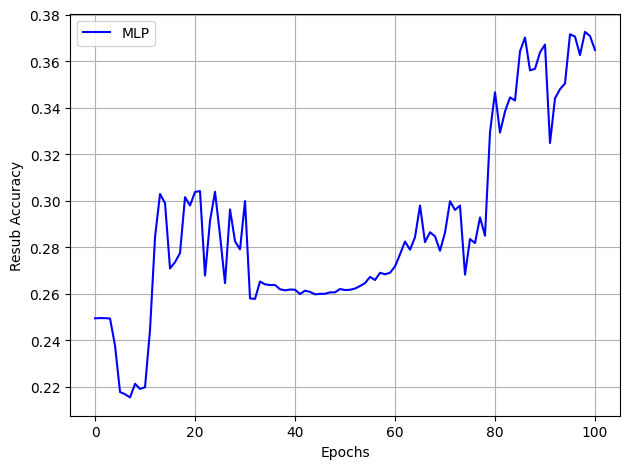

In [29]:
print_result(
    mlp,
    x_train.to_numpy(),
    y_train_cat.to_numpy(),
    x_test.to_numpy(),
    y_test_cat,
    "MLP",
    "blue",
)
plt.show()

This plot shows the resubstitution accuracy of our MLP over 100 epochs. Early training was unstable, but accuracy started improving after epoch 60, reaching about 36.5%.

The validation accuracy is slightly lower at 35.9%, suggesting decent generalization without major overfitting. While the accuracy is pretty low, it reflects the difficulty of the task and shows there's room to improve with better tuning, model changes, and data transformations.

### Apply Normalization to Numeric Features and Retrain the MLP

In [30]:
scaler = StandardScaler().set_output(transform="pandas")
# Scale all features but State
x_train_scaled = x_train.drop(columns=["State"]).copy()
x_test_scaled = x_test.drop(columns=["State"]).copy()
# Fit scaler on training data
scaler.fit(x_train_scaled)
# Transform both training and test data
x_train_scaled = scaler.transform(x_train_scaled)
x_test_scaled = scaler.transform(x_test_scaled)
# Add back the State column
x_train_scaled["State"] = x_train["State"]
x_test_scaled["State"] = x_test["State"]


In [31]:
full_hyper_grid = {
    "eta": [0.000001, 0.00001],  # Learning rates
    "C": [0.0, 0.001, 0.01],  # Regularization strengths
    "n_hidden": [30, 50],  # Number of neurons in hidden layer
    "epochs": [500],  # Number of epochs
}

In [32]:
# scaled_grid_results = grid_search(
#     nn=TLPBetterInitial,
#     x=x_train_scaled.to_numpy(),
#     y=y_train_cat.to_numpy(),
#     param_grid=full_hyper_grid,
# ).sort_values(by="accuracy_mean", ascending=False)

In [33]:
scaled_grid_results = pd.read_csv(
    "grid_search_results/scaled_grid_results.csv"
)
scaled_grid_results.head()
# scaled_grid_results.to_csv("scaled_grid_results.csv", index=False)

,eta,C,n_hidden,epochs,accuracy_mean,accuracy_std
0,0.000010,0.001,30,500,0.544247,0.015732
1,0.000010,0.001,30,500,0.542613,0.018852
2,0.000001,0.001,50,500,0.537199,0.008143
3,0.000001,0.001,50,500,0.533812,0.008549
4,0.000001,0.001,50,500,0.533709,0.014386


In [34]:
scaled_best_params = scaled_grid_results.iloc[0][:4]
scaled_best_params

eta           0.00001
C             0.00100
n_hidden     30.00000
epochs      500.00000
Name: 0, dtype: float64

In [35]:
# scaled_mlp = TLPBetterInitial(
#     eta=scaled_best_params["eta"],
#     C=scaled_best_params["C"],
#     n_hidden=int(scaled_best_params["n_hidden"]),
#     epochs=int(scaled_best_params["epochs"]),
#     random_state=7324,
# )
# Fit the mlp to the scaled data
# scaled_mlp.fit(
#     x_train_scaled.to_numpy(),
#     y_train_cat.to_numpy(),
#     print_progress=10,
# )

In [36]:
# Save the trained model to a file
# write_pkl(
#     scaled_mlp,
#     "models/scaled_2layer.pkl",
# )

# Load the trained model from a file
scaled_mlp = read_pkl(
    "models/scaled_2layer.pkl",
)

In [37]:
# Check the accuracy of the mlp on the test set
yhat_scaled = scaled_mlp.predict(x_test_scaled.to_numpy())
accuracy_score(y_true=y_test_cat, y_pred=yhat_scaled)

0.5239273927392739

MLP w/ Scaling :
Resubstitution acc: 0.5233953312476364
Validation acc: 0.5239273927392739


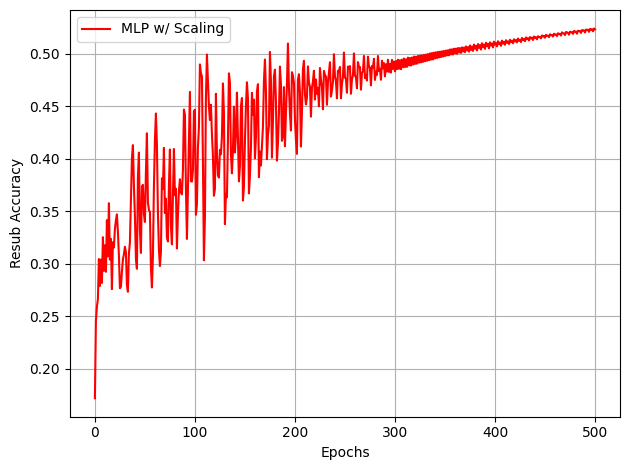

In [38]:
print_result(
    scaled_mlp,
    x_train_scaled.to_numpy(),
    y_train_cat.to_numpy(),
    x_test_scaled.to_numpy(),
    y_test_cat,
    "MLP w/ Scaling",
    "red",
)
plt.show()

After applying feature scaling, the MLP shows a much smoother and more consistent learning curve (aside from the jumpy start which appears to be all over the place). Accuracy steadily improves over 500 epochs, eventually reaching around 52.3% for both training and validation.

The tight gap between the two accuracies suggests the model is generalizing well, and the overall boost in performance compared to the unscaled version highlights the importance of preprocessing.

### Apply One-Hot Encoding to State Column and Retrain the MLP

In [39]:
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
# Fit the encoder on the training data
encoder.fit(x_train_scaled[["State"]])
# Transform both training and test data
x_train_encoded = encoder.transform(x_train_scaled[["State"]])
x_test_encoded = encoder.transform(x_test_scaled[["State"]])
# Concatenate the encoded state columns with the rest of the features
x_train_final = pd.concat(
    [x_train_scaled.drop(columns=["State"]), x_train_encoded],
    axis=1,
)
x_test_final = pd.concat(
    [x_test_scaled.drop(columns=["State"]), x_test_encoded],
    axis=1,
)

In [40]:
# final_grid_results = grid_search(
#     nn=TLPBetterInitial,
#     x=x_train_final.to_numpy(),
#     y=y_train_cat.to_numpy(),
#     param_grid=full_hyper_grid,
# ).sort_values(by="accuracy_mean", ascending=False)
final_grid_results = pd.read_csv(
    "grid_search_results/final_two_layer_grid_results.csv"
)

In [41]:
# final_grid_results.to_csv("final_two_layer_grid_results.csv", index=False)
final_grid_results.head()

,eta,C,n_hidden,epochs,accuracy_mean,accuracy_std
0,0.00001,0.001,30,500,0.668030,0.005587
1,0.00001,0.001,50,500,0.666208,0.006738
2,0.00001,0.001,50,500,0.666122,0.003631
3,0.00001,0.001,50,500,0.662151,0.005439
4,0.00001,0.001,30,500,0.661894,0.007629


In [42]:
final_best_params = final_grid_results.iloc[0][:4]
final_best_params

eta           0.00001
C             0.00100
n_hidden     30.00000
epochs      500.00000
Name: 0, dtype: float64

In [43]:
# Initialize the final mlp with one-hot encoded state
# final_mlp = TLPBetterInitial(
#     eta=final_best_params["eta"],
#     C=final_best_params["C"],
#     n_hidden=int(final_best_params["n_hidden"]),
#     epochs=1500,
#     random_state=7324,
# )
# Fit the final mlp to the one-hot encoded data
# final_mlp.fit(
#     x_train_final.to_numpy(),
#     y_train_cat.to_numpy(),
#     print_progress=10,
# )

In [44]:
# Save the trained model to a file
# write_pkl(
#     final_mlp,
#     "models/final_2layer.pkl",
# )

# Load the trained model from a file
final_mlp = read_pkl(
    "models/final_2layer.pkl",
)

In [45]:
# Check the accuracy of the new mlp on the test set
yhat_final = final_mlp.predict(x_test_final.to_numpy())
accuracy_score(y_true=y_test_cat, y_pred=yhat_final)

0.7238723872387238

MLP w/ Scaling and One-Hot Encoding :
Resubstitution acc: 0.7241723106542441
Validation acc: 0.7238723872387238


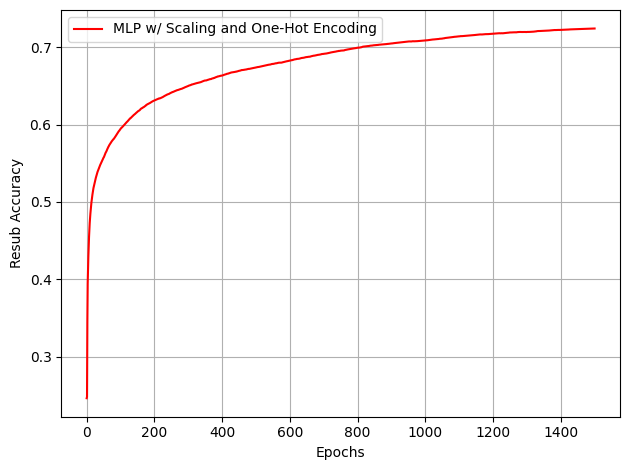

In [46]:
print_result(
    final_mlp,
    x_train_final.to_numpy(),
    y_train_cat.to_numpy(),
    x_test_final.to_numpy(),
    y_test_cat,
    "MLP w/ Scaling and One-Hot Encoding",
    "red",
)
plt.show()

With both feature scaling and one-hot encoding applied, the MLP shows a strong and smooth learning curve. Accuracy climbs quickly and levels off around 72.4% for training and 72.4% for validation, showing excellent generalization.

This is a big jump from the previous runs and really shows how impactful proper data preprocessing can be for model performance.

### Model Performance Comparison

In [47]:
# Run McNemar's test to compare the three classifiers
def mcnemar_test(y_true, y_pred1, y_pred2):
    """Perform McNemar's test to compare two classifiers."""
    # Create a contingency table
    contingency_table = pd.crosstab(y_pred1, y_pred2)
    # Perform McNemar's test
    result = mcnemar(contingency_table)
    return result.statistic, result.pvalue

In [48]:
# Initial model vs. model with scaling
mcnemar_test(y_true=y_test_cat, y_pred1=yhat, y_pred2=yhat_scaled)

(np.float64(0.0), np.float64(4.060706939705039e-115))

Due to the extremely low p-value, we reject the null hypothesis and conclude that the initial model and scaled model are significantly different.

In [49]:
# Scaled model vs. final two-layer model with one-hot encoding
mcnemar_test(y_true=y_test_cat, y_pred1=yhat_scaled, y_pred2=yhat_final)

(np.float64(385.0), np.float64(1.7858051209571057e-18))

Due to the extremely low p-value, we reject the null hypothesis and conclude that the scaled model and one-hot encoded model are significantly different.

From these tests, we can see that both scaling and one-hot encoding have a significant impact on the model's performance. The scaled model performs better than the initial model, and the one-hot encoded model performs better than the scaled model. This suggests that both scaling and one-hot encoding are important preprocessing steps for this dataset.

This is the expected result, as scaling the numeric features removes any variance due to the scale of the numeric features, which helps the model to converge more quickly. One-hot encoding the state column allows this categorical feature to be used in the model, which can provide additional information for the model to learn from.

## Modeling

### Three-Layer Perceptron

In [50]:
class ThreeLayerPerceptronBase:
    def __init__(
        self,
        n_hidden=20,
        n_hidden1=30,
        C=0.0,
        epochs=500,
        eta=0.00001,
        random_state=None,
    ):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.n_hidden1 = n_hidden1
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T

        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_) * self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_)  # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))

        W2_num_elems = (self.n_features_) * self.n_hidden1
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden1, self.n_features_)
        b2 = np.zeros((self.n_hidden1, 1))

        W3_num_elems = (self.n_hidden1) * self.n_output_
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_output_, self.n_hidden1)
        b3 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, b1, b2, b3

    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_ / 3.0) * np.sqrt(
            np.mean(W1[:, 1:] ** 2)
            + np.mean(W2[:, 1:] ** 2)
            + (np.mean(W3[:, 1:] ** 2)),
        )

    def _cost(self, A3, Y_enc, W1, W2, W3):
        """Get the objective function value"""
        cost = np.mean((Y_enc - A3) ** 2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term

    def _feedforward(self, X, W1, W2, W3, b1, b2, b3):
        """Compute feedforward step.

        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        return A1, Z1, A2, Z2, A3, Z3, A4

    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """Compute gradient step using backpropagation."""
        # vectorized backpropagation
        # This uses MSE as cost function
        V3 = -2 * (Y_enc - A4) * A4 * (1 - A4)
        V2 = -2 * (Y_enc - A3) * A3 * (1 - A3)
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb3 = np.sum(V3, axis=1).reshape((-1, 1))
        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1, axis=1).reshape((-1, 1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C

        return gradW1, gradW2, gradW3, gradb1, gradb2, gradb3

    def predict(self, X):
        """Predict class labels."""
        _, _, _, _, _, _, A4 = self._feedforward(
            X,
            self.W1,
            self.W2,
            self.W3,
            self.b1,
            self.b2,
            self.b3,
        )
        y_pred = np.argmax(A4, axis=0)
        return y_pred

In [51]:
class ThreeLPMiniBatch(ThreeLayerPerceptronBase):
    def __init__(
        self,
        shuffle=True,
        minibatches=1,
        **kwds,
    ):
        # need to add to the original initializer
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)

    def fit(self, X, y, print_progress=False, XY_test=None):
        """Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.b1, self.b2, self.b3 = (
            self._initialize_weights()
        )
        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data, self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(
                accuracy_score(y_test, self.predict(X_test)),
            )
            self.val_cost_ = []

        # Add support for saving and plotting the average magnitude of
        # the gradient for each layer, for each epoch
        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        for i in range(self.epochs):
            if print_progress > 0 and (i + 1) % print_progress == 0:
                sys.stderr.write("\rEpoch: %d/%d" % (i + 1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = (
                    X_data[idx_shuffle],
                    Y_enc[:, idx_shuffle],
                    y_data[idx_shuffle],
                )

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []

            grad_w1_mini = np.zeros(len(mini))
            grad_w2_mini = np.zeros(len(mini))
            grad_w3_mini = np.zeros(len(mini))
            for index, idx in enumerate(mini):
                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward(
                    X_data[idx],
                    self.W1,
                    self.W2,
                    self.W3,
                    self.b1,
                    self.b2,
                    self.b3,
                )

                cost = self._cost(
                    A4,
                    Y_enc[:, idx],
                    self.W1,
                    self.W2,
                    self.W3,
                )
                mini_cost.append(
                    cost,
                )  # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradb1, gradb2, gradb3 = (
                    self._get_gradient(
                        A1=A1,
                        A2=A2,
                        A3=A3,
                        A4=A4,
                        Z1=Z1,
                        Z2=Z2,
                        Z3=Z3,
                        Y_enc=Y_enc[:, idx],
                        W1=self.W1,
                        W2=self.W2,
                        W3=self.W3,
                    )
                )

                # Track the magnitude of the gradient
                # Add support for saving and plotting the average magnitude
                # of the gradient for each layer, for each epoch
                grad_w1_mini[index] = np.mean(np.abs(gradW1))
                grad_w2_mini[index] = np.mean(np.abs(gradW2))
                grad_w3_mini[index] = np.mean(np.abs(gradW3))

                # uUdate weights and biases
                rho_W1, rho_W2, rho_W3 = (
                    self.eta * gradW1,
                    self.eta * gradW2,
                    self.eta * gradW3,
                )
                self.W1 -= rho_W1
                self.W2 -= rho_W2
                self.W3 -= rho_W3
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2
                self.b3 -= self.eta * gradb3

            # Track the magnitude of the gradient
            self.grad_w1_[i] = np.mean(grad_w1_mini)
            self.grad_w2_[i] = np.mean(grad_w2_mini)
            self.grad_w3_[i] = np.mean(grad_w3_mini)

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(
                accuracy_score(y_data, self.predict(X_data)),
            )

            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test, yhat))

        return self

In [52]:
class ThreeLPMiniBatchCrossEntropy(ThreeLPMiniBatch):
    def _cost(self, A4, Y_enc, W1, W2, W3):
        """Get the objective function value"""
        cost = -np.mean(
            np.nan_to_num(
                Y_enc * np.log(A4 + 1e-7)
                + (1 - Y_enc) * np.log(1 - A4 + 1e-7),
            ),
        )
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term

    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """Compute gradient step using backpropagation."""
        # vectorized backpropagation
        # Now using cross-entropy as cost function
        V3 = A4 - Y_enc
        V2 = A3 * (1 - A3) * (W3.T @ V3)
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb3 = np.sum(V3, axis=1).reshape((-1, 1))
        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1, axis=1).reshape((-1, 1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C

        return gradW1, gradW2, gradW3, gradb1, gradb2, gradb3

In [53]:
class ThreeLPBetterInitial(ThreeLPMiniBatchCrossEntropy):
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4 * np.sqrt(6.0 / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(
            -init_bound,
            init_bound,
            (self.n_hidden, self.n_features_),
        )

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between
        init_bound = 4 * np.sqrt(6 / (self.n_hidden1 + self.n_features_))
        W2 = np.random.uniform(
            -init_bound,
            init_bound,
            (self.n_hidden1, self.n_hidden),
        )
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between
        init_bound = 4 * np.sqrt(6 / (self.n_output_ + self.n_hidden1))
        W3 = np.random.uniform(
            -init_bound,
            init_bound,
            (self.n_output_, self.n_hidden1),
        )

        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_hidden1, 1))
        b3 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, b1, b2, b3

In [54]:
# Initialize the mlp
# mlp = ThreeLPBetterInitial(random_state=7324, epochs=800)
# Fit the mlp
# mlp.fit(
#     x_train_final.to_numpy(),
#     y_train_cat.to_numpy(),
#     print_progress=10,
# )

In [55]:
# write_pkl(
#     mlp,
#     "models/three_layer.pkl",
# )

mlp = read_pkl(
    "models/three_layer.pkl",
)

In [56]:
# Check the accuracy of the mlp on the test set
yhat = mlp.predict(x_test_final.to_numpy())
accuracy_score(y_true=y_test_cat, y_pred=yhat)

0.7234598459845984

Three-Layer MLP :
Resubstitution acc: 0.7212672327844054
Validation acc: 0.7234598459845984


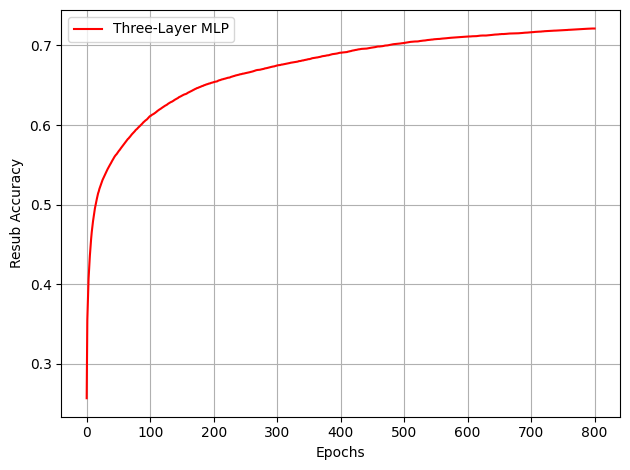

In [57]:
print_result(
    mlp,
    x_train_final.to_numpy(),
    y_train_cat.to_numpy(),
    x_test_final.to_numpy(),
    y_test_cat,
    "Three-Layer MLP",
    "red",
)
plt.show()

The three-layer MLP maintains strong performance, hitting 72.1% training and 72.3% validation accuracy. The learning curve is smooth and consistent, confirming the deeper network’s ability to generalize well.

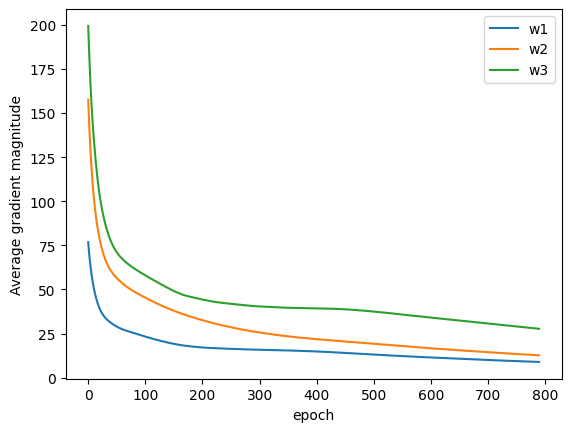

In [58]:
ax = plt.subplot(1, 1, 1)
plt.plot(np.abs(mlp.grad_w1_[10:]), label="w1")
plt.plot(np.abs(mlp.grad_w2_[10:]), label="w2")
plt.plot(np.abs(mlp.grad_w3_[10:]), label="w3")

plt.legend()
plt.ylabel("Average gradient magnitude")
plt.xlabel("epoch")
plt.show()

This plot shows the average gradient magnitude per layer over 800 epochs. All layers experience a sharp drop early on, which is expected as the model converges. Gradients remain stable and continue to decline gradually, indicating smooth learning and no signs of vanishing or exploding gradients.

### Four-Layer Perceptron

In [59]:
class FourLayerPerceptronBase:
    def __init__(
        self,
        n_hidden=30,
        n_hidden1=20,
        n_hidden2=10,
        C=0.0,
        epochs=500,
        eta=0.00001,
        random_state=None,
    ):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T

        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_) * self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_)  # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))

        W2_num_elems = (self.n_features_) * self.n_hidden1
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden1, self.n_features_)
        b2 = np.zeros((self.n_hidden1, 1))

        W3_num_elems = (self.n_features_) * self.n_hidden2
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_hidden2, self.n_features_)
        b3 = np.zeros((self.n_hidden2, 1))

        W4_num_elems = (self.n_hidden2) * self.n_output_
        W4 = np.random.uniform(-1.0, 1.0, size=W4_num_elems)
        W4 = W4.reshape(self.n_output_, self.n_hidden2)
        b4 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, W4, b1, b2, b3, b4

    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_ / 4.0) * np.sqrt(
            np.mean(W1[:, 1:] ** 2)
            + np.mean(W2[:, 1:] ** 2)
            + np.mean(W3[:, 1:] ** 2)
            + np.mean(W4[:, 1:] ** 2),
        )

    def _cost(self, A4, Y_enc, W1, W2, W3, W4):
        """Get the objective function value"""
        cost = np.mean((Y_enc - A4) ** 2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4)
        return cost + L2_term

    def _feedforward(self, X, W1, W2, W3, W4, b1, b2, b3, b4):
        """Compute feedforward step.

        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5

    def _get_gradient(
        self,
        A1,
        A2,
        A3,
        A4,
        A5,
        Z1,
        Z2,
        Z3,
        Z4,
        Y_enc,
        W1,
        W2,
        W3,
        W4,
    ):
        """Compute gradient step using backpropagation."""
        # vectorized backpropagation
        # This uses MSE as cost function
        V4 = -2 * (Y_enc - A5) * A5 * (1 - A5)
        V3 = -2 * (Y_enc - A4) * A4 * (1 - A4)
        V2 = -2 * (Y_enc - A3) * A3 * (1 - A3)
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb4 = np.sum(V4, axis=1).reshape((-1, 1))
        gradb3 = np.sum(V3, axis=1).reshape((-1, 1))
        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1, axis=1).reshape((-1, 1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C

        return (
            gradW1,
            gradW2,
            gradW3,
            gradW4,
            gradb1,
            gradb2,
            gradb3,
            gradb4,
        )

    def predict(self, X):
        """Predict class labels."""
        _, _, _, _, _, _, _, _, A5 = self._feedforward(
            X,
            self.W1,
            self.W2,
            self.W3,
            self.W4,
            self.b1,
            self.b2,
            self.b3,
            self.b4,
        )
        y_pred = np.argmax(A5, axis=0)
        return y_pred

In [60]:
class FourLPMiniBatch(FourLayerPerceptronBase):
    def __init__(
        self,
        shuffle=True,
        minibatches=1,
        **kwds,
    ):
        # need to add to the original initializer
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)

    def fit(self, X, y, print_progress=False, XY_test=None):
        """Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        (
            self.W1,
            self.W2,
            self.W3,
            self.W4,
            self.b1,
            self.b2,
            self.b3,
            self.b4,
        ) = self._initialize_weights()
        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data, self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(
                accuracy_score(y_test, self.predict(X_test))
            )
            self.val_cost_ = []

        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)

        for i in range(self.epochs):
            if print_progress > 0 and (i + 1) % print_progress == 0:
                sys.stderr.write("\rEpoch: %d/%d" % (i + 1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = (
                    X_data[idx_shuffle],
                    Y_enc[:, idx_shuffle],
                    y_data[idx_shuffle],
                )

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            grad_w1_mini = np.zeros(len(mini))
            grad_w2_mini = np.zeros(len(mini))
            grad_w3_mini = np.zeros(len(mini))
            grad_w4_mini = np.zeros(len(mini))
            for index, idx in enumerate(mini):
                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5 = self._feedforward(
                    X_data[idx],
                    self.W1,
                    self.W2,
                    self.W3,
                    self.W4,
                    self.b1,
                    self.b2,
                    self.b3,
                    self.b4,
                )

                cost = self._cost(
                    A5, Y_enc[:, idx], self.W1, self.W2, self.W3, self.W4
                )
                mini_cost.append(
                    cost
                )  # this appends cost of mini-batch only

                # compute gradient via backpropagation
                (
                    gradW1,
                    gradW2,
                    gradW3,
                    gradW4,
                    gradb1,
                    gradb2,
                    gradb3,
                    gradb4,
                ) = self._get_gradient(
                    A1=A1,
                    A2=A2,
                    A3=A3,
                    A4=A4,
                    A5=A5,
                    Z1=Z1,
                    Z2=Z2,
                    Z3=Z3,
                    Z4=Z4,
                    Y_enc=Y_enc[:, idx],
                    W1=self.W1,
                    W2=self.W2,
                    W3=self.W3,
                    W4=self.W4,
                )

                grad_w1_mini[index] = np.mean(np.abs(gradW1))
                grad_w2_mini[index] = np.mean(np.abs(gradW2))
                grad_w3_mini[index] = np.mean(np.abs(gradW3))
                grad_w4_mini[index] = np.mean(np.abs(gradW4))

                # uUdate weights and biases
                rho_W1, rho_W2, rho_W3, rho_W4 = (
                    self.eta * gradW1,
                    self.eta * gradW2,
                    self.eta * gradW3,
                    self.eta * gradW4,
                )
                self.W1 -= rho_W1
                self.W2 -= rho_W2
                self.W3 -= rho_W3
                self.W4 -= rho_W4
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2
                self.b3 -= self.eta * gradb3
                self.b4 -= self.eta * gradb4

            self.grad_w1_[i] = np.mean(grad_w1_mini)
            self.grad_w2_[i] = np.mean(grad_w2_mini)
            self.grad_w3_[i] = np.mean(grad_w3_mini)

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(
                accuracy_score(y_data, self.predict(X_data))
            )

            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test, yhat))

        return self

In [61]:
class FourLPMiniBatchCrossEntropy(FourLPMiniBatch):
    def _cost(self, A5, Y_enc, W1, W2, W3, W4):
        """Get the objective function value"""
        cost = -np.mean(
            np.nan_to_num(
                (
                    Y_enc * np.log(A5 + 1e-7)
                    + (1 - Y_enc) * np.log(1 - A5 + 1e-7)
                )
            )
        )
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4)
        return cost + L2_term

    def _get_gradient(
        self, A1, A2, A3, A4, A5, Z1, Z2, Z3, Z4, Y_enc, W1, W2, W3, W4
    ):
        """Compute gradient step using backpropagation."""
        # vectorized backpropagation
        # Now using cross-entropy as cost function
        V4 = A5 - Y_enc
        V3 = A4 * (1 - A4) * (W4.T @ V4)
        V2 = A3 * (1 - A3) * (W3.T @ V3)
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb4 = np.sum(V4, axis=1).reshape((-1, 1))
        gradb3 = np.sum(V3, axis=1).reshape((-1, 1))
        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1, axis=1).reshape((-1, 1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C

        return (
            gradW1,
            gradW2,
            gradW3,
            gradW4,
            gradb1,
            gradb2,
            gradb3,
            gradb4,
        )

In [62]:
class FourLPBetterInitial(FourLPMiniBatchCrossEntropy):
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4 * np.sqrt(6.0 / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(
            -init_bound, init_bound, (self.n_hidden, self.n_features_)
        )

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between
        init_bound = 4 * np.sqrt(6 / (self.n_hidden1 + self.n_hidden))
        W2 = np.random.uniform(
            -init_bound, init_bound, (self.n_hidden1, self.n_hidden)
        )
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between
        init_bound = 4 * np.sqrt(6 / (self.n_hidden2 + self.n_hidden1))
        W3 = np.random.uniform(
            -init_bound, init_bound, (self.n_hidden2, self.n_hidden1)
        )

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between
        init_bound = 4 * np.sqrt(6 / (self.n_output_ + self.n_hidden2))
        W4 = np.random.uniform(
            -init_bound, init_bound, (self.n_output_, self.n_hidden2)
        )

        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_hidden1, 1))
        b3 = np.zeros((self.n_hidden2, 1))
        b4 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, W4, b1, b2, b3, b4

In [63]:
# Initialize the mlp
# mlp = FourLPBetterInitial(random_state=7324, epochs=800)
# Fit the mlp
# mlp.fit(
#     x_train_final.to_numpy(),
#     y_train_cat.to_numpy(),
#     print_progress=10,
# )

In [64]:
# write_pkl(
#     mlp,
#     "models/four_layer.pkl",
# )
# Load the trained model from a file
mlp = read_pkl(
    "models/four_layer.pkl",
)

In [65]:
# Check the accuracy of the mlp on the test set
yhat = mlp.predict(x_test_final.to_numpy())
accuracy_score(y_true=y_test_cat, y_pred=yhat)

0.7244224422442245

MLP w/ Scaling :
Resubstitution acc: 0.7235706673084196
Validation acc: 0.7244224422442245


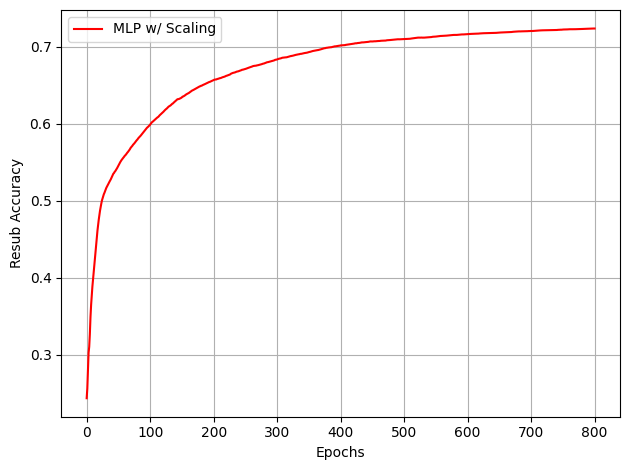

In [66]:
print_result(
    mlp,
    x_train_final.to_numpy(),
    y_train_cat.to_numpy(),
    x_test_final.to_numpy(),
    y_test_cat,
    "MLP w/ Scaling",
    "red",
)
plt.show()

This four-layer MLP with scaling shows strong, steady improvement across 800 epochs, reaching 72.4% validation accuracy. The learning curve is smooth and consistent, indicating stable training and excellent generalization. Accuracy achieved is very comparable to that of our 3-layer model. 

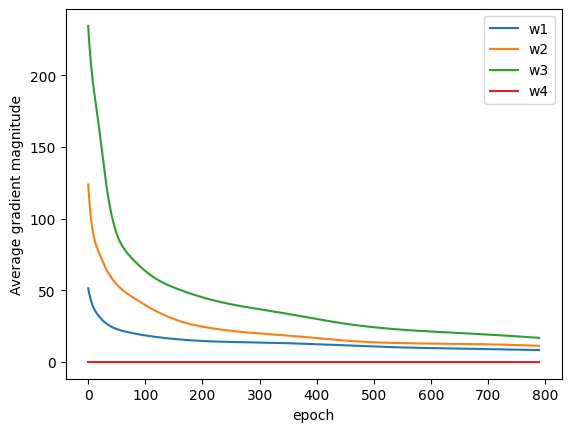

In [67]:
ax = plt.subplot(1, 1, 1)
plt.plot(np.abs(mlp.grad_w1_[10:]), label="w1")
plt.plot(np.abs(mlp.grad_w2_[10:]), label="w2")
plt.plot(np.abs(mlp.grad_w3_[10:]), label="w3")
plt.plot(np.abs(mlp.grad_w4_[10:]), label="w4")


plt.legend()
plt.ylabel("Average gradient magnitude")
plt.xlabel("epoch")
plt.show()


This plot shows average gradient magnitudes for each weight layer in the four-layer MLP. While layers 1–3 follow the expected declining trend, the fourth layer (w4) shows nearly zero gradients throughout training — a sign of vanishing gradients, which may limit learning in the final layer.

### Five-Layer Perceptron

We choose AdaDelta for adaptive learning strategies, because it doesn't need to set learning rate manually, making it more stable. And AdaDelta could dynamically adjust the learning rate based on historical gradient and update information

In [68]:
def update_AdaDelta(W, gradW, V_k, M_k, rho, epsilon):
    V_k = rho * V_k + (1 - rho) * (gradW**2)
    update = (np.sqrt(M_k + epsilon) / np.sqrt(V_k + epsilon)) * gradW
    M_k = rho * M_k + (1 - rho) * (update**2)
    W -= update
    return W, V_k, M_k


def update_Adam(W, gradW, m, v, t, beta1, beta2, eta, epsilon):
    m = beta1 * m + (1 - beta1) * gradW
    v = beta2 * v + (1 - beta2) * (gradW**2)
    m_hat = m / (1 - beta1**t)
    v_hat = v / (1 - beta2**t)
    W -= eta * m_hat / (np.sqrt(v_hat) + epsilon)
    return W, m, v


In [69]:
class FiveLayerPerceptronBase(object):
    def __init__(
        self,
        n_hidden=30,
        n_hidden1=20,
        n_hidden2=10,
        n_hidden3=5,
        C=0.0,
        epochs=500,
        eta=0.00001,
        random_state=None,
    ):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_hidden3 = n_hidden3
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T

        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_) * self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_)  # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))

        W2_num_elems = (self.n_hidden) * self.n_hidden1
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden1, self.n_hidden)
        b2 = np.zeros((self.n_hidden1, 1))

        W3_num_elems = (self.n_hidden1) * self.n_hidden2
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_hidden2, self.n_hidden1)
        b3 = np.zeros((self.n_hidden2, 1))

        W4_num_elems = (self.n_hidden2) * self.n_hidden3
        W4 = np.random.uniform(-1.0, 1.0, size=W4_num_elems)
        W4 = W4.reshape(self.n_hidden3, self.n_hidden2)
        b4 = np.zeros((self.n_hidden3, 1))

        W5_num_elems = (self.n_hidden3) * self.n_output_
        W5 = np.random.uniform(-1.0, 1.0, size=W5_num_elems)
        W5 = W5.reshape(self.n_output_, self.n_hidden3)
        b5 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, W4, W5, b1, b2, b3, b4, b5

    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_ / 5.0) * np.sqrt(
            np.mean(W1[:, 1:] ** 2)
            + np.mean(W2[:, 1:] ** 2)
            + np.mean(W3[:, 1:] ** 2)
            + np.mean(W4[:, 1:] ** 2)
            + np.mean(W5[:, 1:] ** 2)
        )

    def _cost(self, A5, Y_enc, W1, W2, W3, W4, W5):
        """Get the objective function value"""
        cost = np.mean((Y_enc - A5) ** 2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term

    def _feedforward(self, X, W1, W2, W3, W4, W5, b1, b2, b3, b4, b5):
        """Compute feedforward step.

        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)
        Z5 = W5 @ A5 + b5
        A6 = self._sigmoid(Z5)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6

    def _get_gradient(
        self,
        A1,
        A2,
        A3,
        A4,
        A5,
        A6,
        Z1,
        Z2,
        Z3,
        Z4,
        Z5,
        Y_enc,
        W1,
        W2,
        W3,
        W4,
        W5,
    ):
        """Compute gradient step using backpropagation."""
        # vectorized backpropagation
        # This uses MSE as cost function
        V5 = -2 * (Y_enc - A6) * A6 * (1 - A6)
        V4 = A5 * (1 - A5) * (W5.T @ V5)
        V3 = A4 * (1 - A4) * (W4.T @ V4)
        V2 = A3 * (1 - A3) * (W3.T @ V3)
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW5 = V5 @ A5.T
        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb5 = np.sum(V5, axis=1).reshape((-1, 1))
        gradb4 = np.sum(V4, axis=1).reshape((-1, 1))
        gradb3 = np.sum(V3, axis=1).reshape((-1, 1))
        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1, axis=1).reshape((-1, 1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C
        gradW5 += W5 * self.l2_C

        return (
            gradW1,
            gradW2,
            gradW3,
            gradW4,
            gradW5,
            gradb1,
            gradb2,
            gradb3,
            gradb4,
            gradb5,
        )

    def predict(self, X):
        """Predict class labels."""
        _, _, _, _, _, _, _, _, _, _, A6 = self._feedforward(
            X,
            self.W1,
            self.W2,
            self.W3,
            self.W4,
            self.W5,
            self.b1,
            self.b2,
            self.b3,
            self.b4,
            self.b5,
        )
        y_pred = np.argmax(A6, axis=0)
        return y_pred

In [70]:
class FiveLPMiniBatch(FiveLayerPerceptronBase):
    def __init__(
        self,
        shuffle=True,
        minibatches=1,
        rho=0.5,
        epsilon=0.1,
        beta1=0.5,
        beta2=0.5,
        ada_method=None,
        **kwds,
    ):
        # need to add to the original initializer
        self.shuffle = shuffle
        self.minibatches = minibatches
        self.rho = rho
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
        # but keep other keywords
        super().__init__(**kwds)

    def fit(
        self, X, y, print_progress=False, XY_test=None, ada_method=None
    ):
        """Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        (
            self.W1,
            self.W2,
            self.W3,
            self.W4,
            self.W5,
            self.b1,
            self.b2,
            self.b3,
            self.b4,
            self.b5,
        ) = self._initialize_weights()
        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data, self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(
                accuracy_score(y_test, self.predict(X_test))
            )
            self.val_cost_ = []

        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)
        self.grad_w5_ = np.zeros(self.epochs)

        # Initialize accumulators for AdaDelta

        self.V = [
            np.zeros_like(w)
            for w in [
                self.W1,
                self.W2,
                self.W3,
                self.W4,
                self.W5,
                self.b1,
                self.b2,
                self.b3,
                self.b4,
                self.b5,
            ]
        ]
        self.M = [
            np.zeros_like(w)
            for w in [
                self.W1,
                self.W2,
                self.W3,
                self.W4,
                self.W5,
                self.b1,
                self.b2,
                self.b3,
                self.b4,
                self.b5,
            ]
        ]

        # One-time initialization of Adam accumulators

        self.m_W = [
            np.zeros_like(w)
            for w in [
                self.W1,
                self.W2,
                self.W3,
                self.W4,
                self.W5,
                self.b1,
                self.b2,
                self.b3,
                self.b4,
                self.b5,
            ]
        ]
        self.v_W = [
            np.zeros_like(w)
            for w in [
                self.W1,
                self.W2,
                self.W3,
                self.W4,
                self.W5,
                self.b1,
                self.b2,
                self.b3,
                self.b4,
                self.b5,
            ]
        ]

        # self.m_W = [np.zeros_like(w) for w in [self.W1, self.W2, self.W3, self.W4, self.W5]]
        # self.v_W = [np.zeros_like(w) for w in [self.W1, self.W2, self.W3, self.W4, self.W5]]
        # self.m_b = [np.zeros_like(b) for b in [self.b1, self.b2, self.b3, self.b4, self.b5]]
        # self.v_b = [np.zeros_like(b) for b in [self.b1, self.b2, self.b3, self.b4, self.b5]]

        for i in range(self.epochs):
            if print_progress > 0 and (i + 1) % print_progress == 0:
                sys.stderr.write("\rEpoch: %d/%d" % (i + 1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = (
                    X_data[idx_shuffle],
                    Y_enc[:, idx_shuffle],
                    y_data[idx_shuffle],
                )

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            grad_w1_mini = np.zeros(len(mini))
            grad_w2_mini = np.zeros(len(mini))
            grad_w3_mini = np.zeros(len(mini))
            grad_w4_mini = np.zeros(len(mini))
            grad_w5_mini = np.zeros(len(mini))
            for index, idx in enumerate(mini):
                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = (
                    self._feedforward(
                        X_data[idx],
                        self.W1,
                        self.W2,
                        self.W3,
                        self.W4,
                        self.W5,
                        self.b1,
                        self.b2,
                        self.b3,
                        self.b4,
                        self.b5,
                    )
                )

                cost = self._cost(
                    A6,
                    Y_enc[:, idx],
                    self.W1,
                    self.W2,
                    self.W3,
                    self.W4,
                    self.W5,
                )
                mini_cost.append(
                    cost
                )  # this appends cost of mini-batch only

                # compute gradient via backpropagation
                (
                    gradW1,
                    gradW2,
                    gradW3,
                    gradW4,
                    gradW5,
                    gradb1,
                    gradb2,
                    gradb3,
                    gradb4,
                    gradb5,
                ) = self._get_gradient(
                    A1=A1,
                    A2=A2,
                    A3=A3,
                    A4=A4,
                    A5=A5,
                    A6=A6,
                    Z1=Z1,
                    Z2=Z2,
                    Z3=Z3,
                    Z4=Z4,
                    Z5=Z5,
                    Y_enc=Y_enc[:, idx],
                    W1=self.W1,
                    W2=self.W2,
                    W3=self.W3,
                    W4=self.W4,
                    W5=self.W5,
                )

                grad_w1_mini[index] = np.mean(np.abs(gradW1))
                grad_w2_mini[index] = np.mean(np.abs(gradW2))
                grad_w3_mini[index] = np.mean(np.abs(gradW3))
                grad_w4_mini[index] = np.mean(np.abs(gradW4))
                grad_w5_mini[index] = np.mean(np.abs(gradW5))

                if ada_method is None:
                    # uUdate weights and biases
                    rho_W1, rho_W2, rho_W3, rho_W4, rho_W5 = (
                        self.eta * gradW1,
                        self.eta * gradW2,
                        self.eta * gradW3,
                        self.eta * gradW4,
                        self.eta * gradW5,
                    )
                    self.W1 -= rho_W1
                    self.W2 -= rho_W2
                    self.W3 -= rho_W3
                    self.W4 -= rho_W4
                    self.W5 -= rho_W5
                    self.b1 -= self.eta * gradb1
                    self.b2 -= self.eta * gradb2
                    self.b3 -= self.eta * gradb3
                    self.b4 -= self.eta * gradb4
                    self.b5 -= self.eta * gradb5
                elif ada_method == "update_AdaDelta":
                    # -----------------start applying adadelta-----
                    # Update weights using AdaDelta
                    self.W1, self.V[0], self.M[0] = update_AdaDelta(
                        self.W1,
                        gradW1,
                        self.V[0],
                        self.M[0],
                        self.rho,
                        self.epsilon,
                    )
                    self.W2, self.V[1], self.M[1] = update_AdaDelta(
                        self.W2,
                        gradW2,
                        self.V[1],
                        self.M[1],
                        self.rho,
                        self.epsilon,
                    )
                    self.W3, self.V[2], self.M[2] = update_AdaDelta(
                        self.W3,
                        gradW3,
                        self.V[2],
                        self.M[2],
                        self.rho,
                        self.epsilon,
                    )
                    self.W4, self.V[3], self.M[3] = update_AdaDelta(
                        self.W4,
                        gradW4,
                        self.V[3],
                        self.M[3],
                        self.rho,
                        self.epsilon,
                    )
                    self.W5, self.V[4], self.M[4] = update_AdaDelta(
                        self.W5,
                        gradW5,
                        self.V[4],
                        self.M[4],
                        self.rho,
                        self.epsilon,
                    )

                    self.b1, self.V[5], self.M[5] = update_AdaDelta(
                        self.b1,
                        gradb1,
                        self.V[5],
                        self.M[5],
                        self.rho,
                        self.epsilon,
                    )
                    self.b2, self.V[6], self.M[6] = update_AdaDelta(
                        self.b2,
                        gradb2,
                        self.V[6],
                        self.M[6],
                        self.rho,
                        self.epsilon,
                    )
                    self.b3, self.V[7], self.M[7] = update_AdaDelta(
                        self.b3,
                        gradb3,
                        self.V[7],
                        self.M[7],
                        self.rho,
                        self.epsilon,
                    )
                    self.b4, self.V[8], self.M[8] = update_AdaDelta(
                        self.b4,
                        gradb4,
                        self.V[8],
                        self.M[8],
                        self.rho,
                        self.epsilon,
                    )
                    self.b5, self.V[9], self.M[9] = update_AdaDelta(
                        self.b5,
                        gradb5,
                        self.V[9],
                        self.M[9],
                        self.rho,
                        self.epsilon,
                    )
                    # -----------------end applying adadelta-----
                elif ada_method == "update_Adam":
                    t = i + 1  # current epoch step
                    self.W1, self.m_W[0], self.v_W[0] = update_Adam(
                        self.W1,
                        gradW1,
                        self.m_W[0],
                        self.v_W[0],
                        t,
                        self.beta1,
                        self.beta2,
                        self.eta,
                        self.epsilon,
                    )
                    self.W2, self.m_W[1], self.v_W[1] = update_Adam(
                        self.W2,
                        gradW2,
                        self.m_W[1],
                        self.v_W[1],
                        t,
                        self.beta1,
                        self.beta2,
                        self.eta,
                        self.epsilon,
                    )
                    self.W3, self.m_W[2], self.v_W[2] = update_Adam(
                        self.W3,
                        gradW3,
                        self.m_W[2],
                        self.v_W[2],
                        t,
                        self.beta1,
                        self.beta2,
                        self.eta,
                        self.epsilon,
                    )
                    self.W4, self.m_W[3], self.v_W[3] = update_Adam(
                        self.W4,
                        gradW4,
                        self.m_W[3],
                        self.v_W[3],
                        t,
                        self.beta1,
                        self.beta2,
                        self.eta,
                        self.epsilon,
                    )
                    self.W5, self.m_W[4], self.v_W[4] = update_Adam(
                        self.W5,
                        gradW5,
                        self.m_W[4],
                        self.v_W[4],
                        t,
                        self.beta1,
                        self.beta2,
                        self.eta,
                        self.epsilon,
                    )

                    self.b1, self.m_W[5], self.v_W[5] = update_Adam(
                        self.b1,
                        gradb1,
                        self.m_W[5],
                        self.v_W[5],
                        t,
                        self.beta1,
                        self.beta2,
                        self.eta,
                        self.epsilon,
                    )
                    self.b2, self.m_W[6], self.v_W[6] = update_Adam(
                        self.b2,
                        gradb2,
                        self.m_W[6],
                        self.v_W[6],
                        t,
                        self.beta1,
                        self.beta2,
                        self.eta,
                        self.epsilon,
                    )
                    self.b3, self.m_W[7], self.v_W[7] = update_Adam(
                        self.b3,
                        gradb3,
                        self.m_W[7],
                        self.v_W[7],
                        t,
                        self.beta1,
                        self.beta2,
                        self.eta,
                        self.epsilon,
                    )
                    self.b4, self.m_W[8], self.v_W[8] = update_Adam(
                        self.b4,
                        gradb4,
                        self.m_W[8],
                        self.v_W[8],
                        t,
                        self.beta1,
                        self.beta2,
                        self.eta,
                        self.epsilon,
                    )
                    self.b5, self.m_W[9], self.v_W[9] = update_Adam(
                        self.b5,
                        gradb5,
                        self.m_W[9],
                        self.v_W[9],
                        t,
                        self.beta1,
                        self.beta2,
                        self.eta,
                        self.epsilon,
                    )

            self.grad_w1_[i] = np.mean(grad_w1_mini)
            self.grad_w2_[i] = np.mean(grad_w2_mini)
            self.grad_w3_[i] = np.mean(grad_w3_mini)
            self.grad_w4_[i] = np.mean(grad_w4_mini)
            self.grad_w5_[i] = np.mean(grad_w5_mini)

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(
                accuracy_score(y_data, self.predict(X_data))
            )

            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test, yhat))

        return self


In [71]:
class FiveLPMiniBatchCrossEntropy(FiveLPMiniBatch):
    def _cost(self, A6, Y_enc, W1, W2, W3, W4, W5):
        """Get the objective function value"""
        cost = -np.mean(
            np.nan_to_num(
                (
                    Y_enc * np.log(A6 + 1e-7)
                    + (1 - Y_enc) * np.log(1 - A6 + 1e-7)
                )
            )
        )
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term

    def _get_gradient(
        self,
        A1,
        A2,
        A3,
        A4,
        A5,
        A6,
        Z1,
        Z2,
        Z3,
        Z4,
        Z5,
        Y_enc,
        W1,
        W2,
        W3,
        W4,
        W5,
    ):
        """Compute gradient step using backpropagation."""
        # vectorized backpropagation
        # Now using cross-entropy as cost function

        V5 = A6 - Y_enc
        V4 = A5 * (1 - A5) * (W5.T @ V5)
        V3 = A4 * (1 - A4) * (W4.T @ V4)
        V2 = A3 * (1 - A3) * (W3.T @ V3)
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW5 = V5 @ A5.T
        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb5 = np.sum(V5, axis=1).reshape((-1, 1))
        gradb4 = np.sum(V4, axis=1).reshape((-1, 1))
        gradb3 = np.sum(V3, axis=1).reshape((-1, 1))
        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1, axis=1).reshape((-1, 1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C
        gradW5 += W5 * self.l2_C

        return (
            gradW1,
            gradW2,
            gradW3,
            gradW4,
            gradW5,
            gradb1,
            gradb2,
            gradb3,
            gradb4,
            gradb5,
        )

In [72]:
class FiveLPBetterInitial(FiveLPMiniBatchCrossEntropy):
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4 * np.sqrt(6.0 / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(
            -init_bound, init_bound, (self.n_hidden, self.n_features_)
        )

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between
        init_bound = 4 * np.sqrt(6 / (self.n_hidden1 + self.n_hidden))
        W2 = np.random.uniform(
            -init_bound, init_bound, (self.n_hidden1, self.n_hidden)
        )
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between
        init_bound = 4 * np.sqrt(6 / (self.n_hidden2 + self.n_hidden1))
        W3 = np.random.uniform(
            -init_bound, init_bound, (self.n_hidden2, self.n_hidden1)
        )

        init_bound = 4 * np.sqrt(6 / (self.n_hidden3 + self.n_hidden2))
        W4 = np.random.uniform(
            -init_bound, init_bound, (self.n_hidden3, self.n_hidden2)
        )

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between
        init_bound = 4 * np.sqrt(6 / (self.n_output_ + self.n_hidden3))
        W5 = np.random.uniform(
            -init_bound, init_bound, (self.n_output_, self.n_hidden3)
        )

        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_hidden1, 1))
        b3 = np.zeros((self.n_hidden2, 1))
        b4 = np.zeros((self.n_hidden3, 1))
        b5 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, W4, W5, b1, b2, b3, b4, b5

#### Without adaptive learning

In [73]:
# Initialize the mlp
# mlp = FiveLPBetterInitial(random_state=7324, epochs=800)
# Fit the mlp
# mlp.fit(
#     x_train_final.to_numpy(),
#     y_train_cat.to_numpy(),
#     print_progress=10,
# )

In [74]:
# write_pkl(
#     mlp,
#     "models/five_layer.pkl",
# )
# Load the trained model from a file
mlp = read_pkl(
    "models/five_layer.pkl",
)

In [75]:
# Check the accuracy of the mlp on the test set
yhat_norm = mlp.predict(x_test_final.to_numpy())
accuracy_score(y_true=y_test_cat, y_pred=yhat_norm)

0.716515401540154

MLP w/ Scaling :
Resubstitution acc: 0.7170213497438719
Validation acc: 0.716515401540154


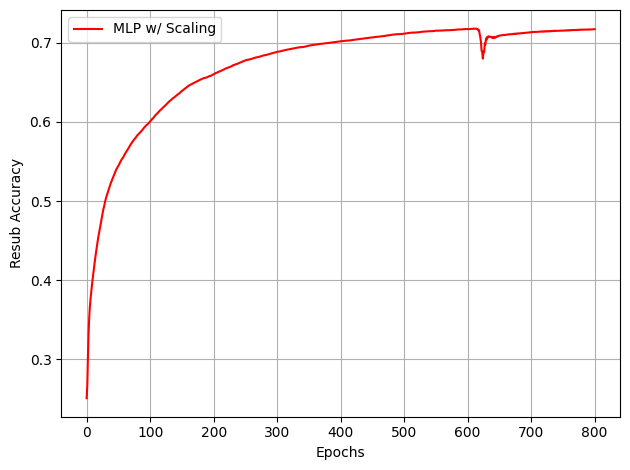

In [76]:
print_result(
    mlp,
    x_train_final.to_numpy(),
    y_train_cat.to_numpy(),
    x_test_final.to_numpy(),
    y_test_cat,
    "MLP w/ Scaling",
    "red",
)
plt.show()

The five-layer MLP with scaling reaches about 71.7% accuracy on both training and validation sets, showing solid generalization. The sharp dip around epoch 600 could indicate a momentary instability, but overall training remains consistent and converges smoothly.

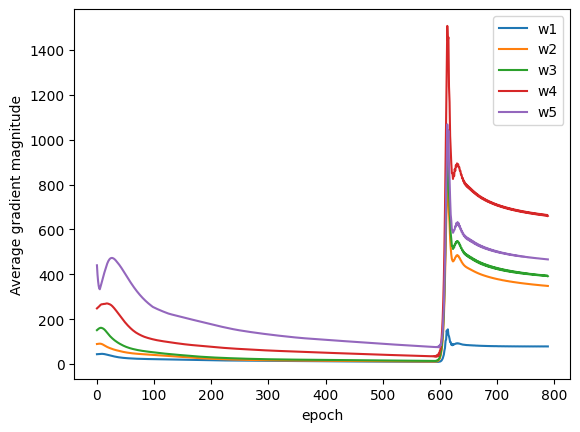

In [77]:
ax = plt.subplot(1, 1, 1)
plt.plot(np.abs(mlp.grad_w1_[10:]), label="w1")
plt.plot(np.abs(mlp.grad_w2_[10:]), label="w2")
plt.plot(np.abs(mlp.grad_w3_[10:]), label="w3")
plt.plot(np.abs(mlp.grad_w4_[10:]), label="w4")
plt.plot(np.abs(mlp.grad_w5_[10:]), label="w5")

plt.legend()
plt.ylabel("Average gradient magnitude")
plt.xlabel("epoch")
plt.show()

This plot shows the average gradient magnitudes across all five layers. Most layers follow a steady decline early on, but around epoch 600 we see a dramatic spike across all weights. This aligns with the dip in accuracy from the previous chart and likely reflects a sudden destabilization in learning — possibly due to a sharp weight update or numerical instability.

#### AdaDelta adaptive learning

In [78]:
# Initialize the mlp
# mlp = FiveLPBetterInitial(
#     random_state=7324, epochs=500, epsilon=1e-6, rho=0.95
# )
# Fit the mlp
# mlp.fit(
#     x_train_final.to_numpy(),
#     y_train_cat.to_numpy(),
#     print_progress=10,
#     ada_method="update_AdaDelta",
# )

In [79]:
# write_pkl(
#     mlp,
#     "models/five_layer_adadelta.pkl",
# )
# Load the trained model from a file
mlp = read_pkl(
    "models/five_layer_adadelta.pkl",
)

In [80]:
# Check the accuracy of the mlp on the test set
yhat_adadelta = mlp.predict(x_test_final.to_numpy())
accuracy_score(y_true=y_test_cat, y_pred=yhat_adadelta)

0.7043454345434543

MLP w/ Scaling :
Resubstitution acc: 0.7089593289098223
Validation acc: 0.7043454345434543


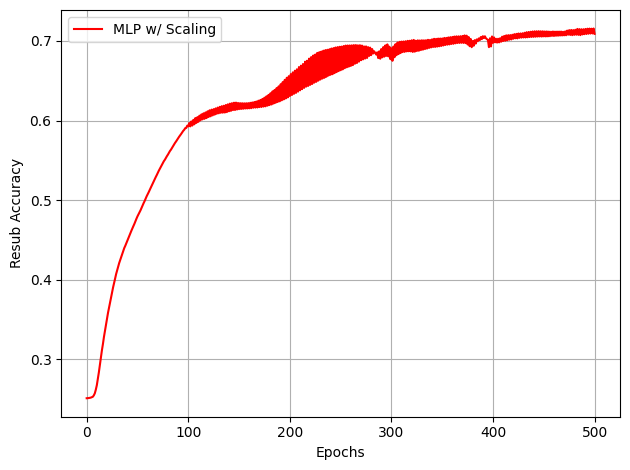

In [81]:
print_result(
    mlp,
    x_train_final.to_numpy(),
    y_train_cat.to_numpy(),
    x_test_final.to_numpy(),
    y_test_cat,
    "MLP w/ Scaling",
    "red",
)
plt.show()

Using AdaDelta for adaptive learning results in a much smoother and more stable convergence. Accuracy rises quickly early on, and despite some oscillation, it gradually levels out just above 70% for both training and validation. The reduced volatility toward the end shows AdaDelta’s effectiveness in adapting the learning rate over time

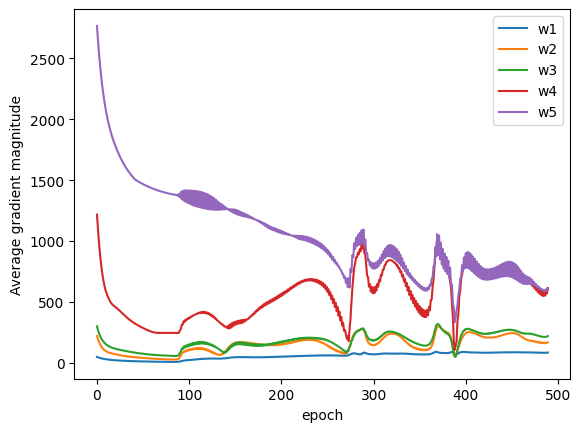

In [82]:
ax = plt.subplot(1, 1, 1)
plt.plot(np.abs(mlp.grad_w1_[10:]), label="w1")
plt.plot(np.abs(mlp.grad_w2_[10:]), label="w2")
plt.plot(np.abs(mlp.grad_w3_[10:]), label="w3")
plt.plot(np.abs(mlp.grad_w4_[10:]), label="w4")
plt.plot(np.abs(mlp.grad_w5_[10:]), label="w5")

plt.legend()
plt.ylabel("Average gradient magnitude")
plt.xlabel("epoch")
plt.show()

This gradient plot shows how AdaDelta adapts weight updates across all five layers. Early on, gradients for deeper layers (especially w5 and w4) are quite large, but they gradually shrink and stabilize. The visible oscillations in mid-to-late training reflect AdaDelta's responsiveness to local changes in loss — it's dynamically adjusting learning rates rather than converging monotonically, which can help escape plateaus.

## Comparsion

From the visualiztion of the average magnitude of the gradient for each layer for each epoch, we can see that:
- without adaptive learning, the average magnitude of the gradient for all W start lower and decay gradually, the values decrease slowly, especially for deeper layers (e.g., w4, w5), indicating the model learns slow. There also appears to be some numerical instability in the gradients, as they spike at certain epochs (e.g., 600), which may indicate that the model is having trouble converging.
- with AdaDelta, the  average magnitude of the gradient for all W start at a very large range(0-3000) and decrease very quickly in the first 25 epoches, indicating that the model learns very quickly. After this initial dip, there is some volitility in the gradients, which highlights the ability for the adaptive learning rate to overcome plateaus.


From the visualiztion of the resubstitution accuracy the classifier as Epoches increase, we can see that:
- the models perform very similarly, both achieving around 70-71% accuracy.

In [89]:
# Perform McNemar's test
mcnemar_test(
    y_true=y_test_cat,
    y_pred1=yhat_norm,
    y_pred2=yhat_adadelta,
)

(np.float64(38.0), np.float64(0.0))

From McNemar's test, we can see that the p-value is 0.0 which indicates that the two models are significantly different. This indicates that even though the models perform very similarly, there is still a significant difference between them.

### AdaM adaptive Learning

In [84]:
# mlp = FiveLPBetterInitial(
#     random_state=7324,
#     epochs=1500,
#     epsilon=1e-8,
#     beta1=0.9,
#     beta2=0.999,
#     eta=0.001,
# )
# Fit the mlp
# mlp.fit(
#     x_train_final.to_numpy(),
#     y_train_cat.to_numpy(),
#     print_progress=10,
#     ada_method="update_Adam",
# )

In [85]:
# write_pkl(
#     mlp,
#     "models/five_layer_adam.pkl",
# )
# Load the trained model from a file
mlp = read_pkl(
    "models/five_layer_adam.pkl",
)

In [90]:
# Check the accuracy of the mlp on the test set
yhat_adam = mlp.predict(x_test_final.to_numpy())
accuracy_score(y_true=y_test_cat, y_pred=yhat_adam)

0.7325357535753575

MLP w/ Scaling :
Resubstitution acc: 0.7386805101935573
Validation acc: 0.7325357535753575


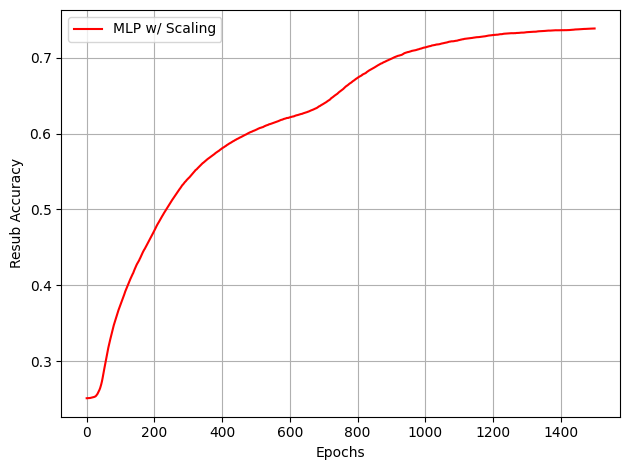

In [87]:
print_result(
    mlp,
    x_train_final.to_numpy(),
    y_train_cat.to_numpy(),
    x_test_final.to_numpy(),
    y_test_cat,
    "MLP w/ Scaling",
    "red",
)
plt.show()

Using Adam optimization, the MLP achieves its best performance so far, reaching about 73.9% training and 73.3% validation accuracy. The learning curve is smooth and consistently rising, showing stable convergence over 1500 epochs. Adam’s adaptive updates clearly help the model learn efficiently and generalize well.

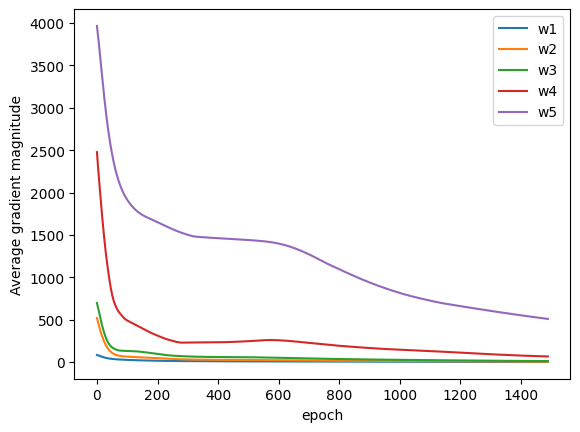

In [88]:
ax = plt.subplot(1, 1, 1)
plt.plot(np.abs(mlp.grad_w1_[10:]), label="w1")
plt.plot(np.abs(mlp.grad_w2_[10:]), label="w2")
plt.plot(np.abs(mlp.grad_w3_[10:]), label="w3")
plt.plot(np.abs(mlp.grad_w4_[10:]), label="w4")
plt.plot(np.abs(mlp.grad_w5_[10:]), label="w5")

plt.legend()
plt.ylabel("Average gradient magnitude")
plt.xlabel("epoch")
plt.show()

This plot shows how Adam manages gradient magnitudes across all five layers of the network. The deeper layers, especially w5 and w4, start with very large gradients but quickly stabilize. This reflects Adam’s ability to adapt learning rates individually for each parameter, helping avoid unstable updates.

Unlike earlier optimizers, there's no sudden spike or oscillation — gradients decrease smoothly over time. The lower layers (w1 to w3) maintain small, consistent gradients, showing that Adam effectively prevents both vanishing and exploding gradients. This stable gradient behavior likely contributes to the strong and reliable performance we saw in the accuracy curve.

### Compare all five-layer MLPs

In [91]:
# Perform McNemar's test
mcnemar_test(
    y_true=y_test_cat,
    y_pred1=yhat_norm,
    y_pred2=yhat_adam,
)

(np.float64(39.0), np.float64(8.455743594471125e-185))

In [92]:
mcnemar_test(
    y_true=y_test_cat,
    y_pred1=yhat_adadelta,
    y_pred2=yhat_adam,
)

(np.float64(125.0), np.float64(3.201628845235628e-92))

Both of these p-values are extremely small, indicating that the modeling using AdaM is significantly different from both other models. This makes sense, as AdaM clearly has the best performance of all the models we have tried so far.